In [1]:
!pip install pylandstats
!pip install xarray-spatial

In [3]:
import pylandstats as pls
import os,glob,time
import numpy as np
from tqdm.auto import tqdm
import rasterio as rio
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
from xrspatial.classify import reclassify
import matplotlib.pyplot as plt
%matplotlib inline

proj = 'EPSG:32613'  # WGS 83 / UTM Zone 13N

# SRME boundary
srme = 'us_eco_l3_srme.gpkg'
# White River boundary
wrnf = 'wrnf_boundary.gpkg'

# Load the classification raster (10-meter)
aspen10m_path = 'aspen_prob_10m_binOpt.tif'
aspen10m = rxr.open_rasterio(aspen10m_path, masked=True).squeeze()
aspen10m = aspen10m.astype(np.uint8)
print("NoData value:")
print(aspen10m.rio.nodata)
print(aspen10m.values)

# Load the classification raster (30-meter)
aspen30m_path = 'aspen_prob_10m_binOpt_max30m.tif'
aspen30m = rxr.open_rasterio(aspen30m_path, masked=True).squeeze()
aspen30m = aspen30m.astype(np.uint8)
print("NoData value:")
print(aspen30m.rio.nodata)
print(aspen30m.values)

# Load the LANDFIRE c. 2016 EVT (for the SRME)
evt30m_path = 'lc16_evt_srme_aspen_r01_utm.tif' 
evt30m = rxr.open_rasterio(evt30m_path, masked=True).squeeze()
evt30m = evt30m.astype(np.uint8)
print("NoData value:")
print(evt30m.rio.nodata)
print(evt30m.values)

NoData value:
None
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
NoData value:
None
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
NoData value:
None
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# Compute Patch-Level Metrics
### For the SRME and the White River NF

Starting for us_eco_l3_srme.gpkg ...
CRS of the shape: PROJCS["North_America_Lambert_Conformal_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",40],PARAMETER["central_meridian",-96],PARAMETER["standard_parallel_1",20],PARAMETER["standard_parallel_2",60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102009"]]; 
Raster: EPSG:32613
Reprojecting to match CRS ...


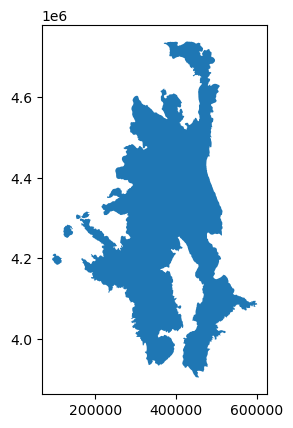

Clipping
Reclassifying
[  0   1 255]
[147156060  15250881 308854444]
Generating Landscape
Starting for wrnf_boundary.gpkg ...
CRS matches!


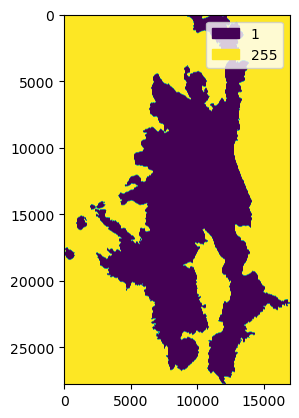

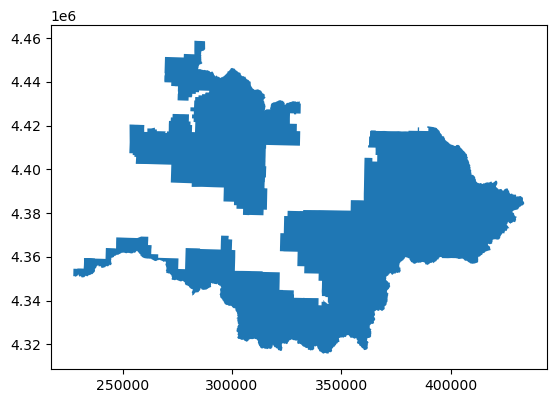

Clipping
Reclassifying
[  0   1 255]
[ 9094422  2249367 21501331]
Generating Landscape
Complete!


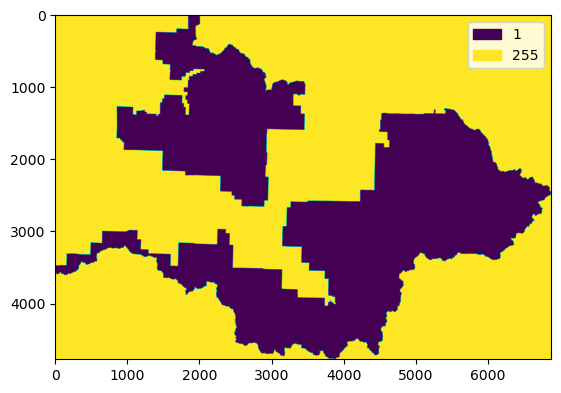

In [4]:
############################################################
# Prep the landscape surfaces for the LANDFIRE EVT c. 2016 #
############################################################

rois = [srme,wrnf]

lss = []
for roi in rois:
    print(f"Starting for {os.path.basename(roi)} ...")
    roi = gpd.read_file(roi)
    if roi.crs == evt30m.rio.crs:
        print("CRS matches!")
    else: 
        print(f"CRS of the shape: {roi.crs}; \nRaster: {evt30m.rio.crs}")
        print("Reprojecting to match CRS ...")
        roi = roi.to_crs(proj)
        evt30m = evt30m.rio.reproject(proj)
    # Plot the boundaries
    f, axx = plt.subplots(1,1)
    roi.plot(ax=axx)
    plt.show()
    # Clip to the ROI
    print("Clipping")
    clipped = evt30m.rio.clip(roi.geometry)
    # Reclassify to remove values of 0 (background)
    print("Reclassifying")
    img = reclassify(clipped, bins=[0,1], new_values=[1,2]).astype(int)
    # Get unique Pixel Values & their Count in numpy array    
    unique, count = np.unique(clipped, return_counts = True)
    print(unique)
    print(count)
    # Convert to landscape object
    print("Generating Landscape")
    ls = pls.Landscape(clipped.values, res=(30,30))
    ls.plot_landscape(legend=True)
    lss.append(ls)
    # Clean up
    del roi, clipped, img, ls
print("Complete!")

In [ ]:
import time
start_time = time.time()

# Patch
print(lss[0].PATCH_METRICS)
metrics_pch = [
    'area', 'perimeter', 'perimeter_area_ratio', 'shape_index'
]

# Class
print(lss[0].CLASS_METRICS)
metrics_class = ['proportion_of_landscape', 'patch_density', 'landscape_shape_index', 'edge_density']

stats=[]
for i in range(len(lss)):
    ls_ = lss[i]
    name = os.path.basename(rois[i])[:-5]
    print(f"Computing patch metrics for the {name} landscape ...")
    # Compute the aspen class metrics 
    patch_mets = ls_.compute_patch_metrics_df(metrics=metrics_pch)
    patch_mets = patch_mets[patch_mets['class_val'] == 2]
    stats.append(patch_mets)
    patch_mets.info()
    print(pd.DataFrame(patch_mets.head()))
    patch_mets.to_csv(f'{name}_patch_metrics_evt30m.csv'))
    print("Successfully exported patch metrics table!")
    print("Computing class metrics ...")
    class_mets = ls_.compute_class_metrics_df(classes=[2], metrics=metrics_class)
    stats.append(class_mets)
    class_mets.info()
    print(pd.DataFrame(class_mets.head()))
    class_mets.to_csv(f'{name}_class_metrics_evt30m.csv'))
    print("Successfully exported class metrics table!")
    # Clean up a bit
    del ls_, patch_mets, class_mets

print(f"Time elapsed: {round(time.time() - start_time, 1)/60} minutes.")

## Compute Patch & Landscape Metrics for the 10m Classification

In [ ]:
start_time = time.time()

del lss  # clean up the old landscapes

lss = []
for roi in rois:
    print(f"Starting for {os.path.basename(roi)} ...")
    roi = gpd.read_file(roi)
    if roi.crs == aspen10m.rio.crs:
        print("CRS matches!")
    else: 
        print(f"CRS of the shape: {roi.crs}; \nRaster: {aspen10m.rio.crs}")
        print("Reprojecting to match CRS ...")
        roi = roi.to_crs(proj)
        aspen10m = aspen10m.rio.reproject(proj)
    # Plot the boundaries
    f, axx = plt.subplots(1,1)
    roi.plot(ax=axx)
    plt.show()
    # Clip to the ROI
    print("Clipping")
    clipped = aspen10m.rio.clip(roi.geometry)
    # Reclassify to remove values of 0 (background)
    print("Reclassifying")
    img = reclassify(clipped, bins=[0,1], new_values=[1,2]).astype(int)
    print(img.values)
    # Get unique Pixel Values & their Count in numpy array    
    unique, count = np.unique(img, return_counts = True)
    print(unique)
    print(count)
    # Convert to landscape object
    print("Generating Landscape")
    ls = pls.Landscape(img.values, res=(10,10))
    ls.plot_landscape(legend=True)
    lss.append(ls)
print("Complete!")
print(f"Time elapsed: {round(time.time() - start_time, 1)/60} minutes.")

In [ ]:
start_time = time.time()

# Patch
print(lss[0].PATCH_METRICS)
metrics_pch = [
    'area', 'perimeter', 'perimeter_area_ratio', 'shape_index'
]

# Class
print(lss[0].CLASS_METRICS)
metrics_class = ['proportion_of_landscape', 'patch_density', 'landscape_shape_index', 'edge_density']

stats=[]
for i in range(len(lss)):
    ls_ = lss[i]
    name = os.path.basename(rois[i])[:-5]
    print(f"Computing patch metrics for the {name} landscape ...")
    # Compute the aspen class metrics 
    patch_mets = ls_.compute_patch_metrics_df(metrics=metrics_pch)
    patch_mets = patch_mets[patch_mets['class_val'] == 2]
    stats.append(patch_mets)
    patch_mets.info()
    print(pd.DataFrame(patch_mets.head()))
    patch_mets.to_csv(f'{name}_patch_metrics_10m.csv'))
    print("Successfully exported patch metrics table!")
    print("Computing class metrics ...")
    class_mets = ls_.compute_class_metrics_df(classes=[2], metrics=metrics_class)
    stats.append(class_mets)
    class_mets.info()
    print(pd.DataFrame(class_mets.head()))
    class_mets.to_csv(f'{name}_class_metrics_10m.csv'))
    print("Successfully exported class metrics table!")
    # Clean up a bit
    del ls_, patch_mets, class_mets

print(f"Time elapsed: {round(time.time() - start_time, 1)/60} minutes.")

In [ ]:
start_time = time.time()

del lss  # clean up the old landscapes

lss = []
for roi in rois:
    print(f"Starting for {os.path.basename(roi)} ...")
    roi = gpd.read_file(roi)
    if roi.crs == aspen30m.rio.crs:
        print("CRS matches!")
    else: 
        print(f"CRS of the shape: {roi.crs}; \nRaster: {aspen30m.rio.crs}")
        print("Reprojecting to match CRS ...")
        roi = roi.to_crs(proj)
        aspen30m = aspen30m.rio.reproject(proj)
    # Plot the boundaries
    f, axx = plt.subplots(1,1)
    roi.plot(ax=axx)
    plt.show()
    # Clip to the ROI
    print("Clipping")
    clipped = aspen30m.rio.clip(roi.geometry)
    # Reclassify to remove values of 0 (background)
    print("Reclassifying")
    img = reclassify(clipped, bins=[0,1], new_values=[1,2]).astype(int)
    print(img.values)
    # Get unique Pixel Values & their Count in numpy array    
    unique, count = np.unique(img, return_counts = True)
    print(unique)
    print(count)
    # Convert to landscape object
    print("Generating Landscape")
    ls = pls.Landscape(img.values, res=(10,10))
    ls.plot_landscape(legend=True)
    lss.append(ls)
print("Complete!")
print(f"Time elapsed: {round(time.time() - start_time, 1)/60} minutes.")

In [ ]:
start_time = time.time()

# Patch
print(lss[0].PATCH_METRICS)
metrics_pch = [
    'area', 'perimeter', 'perimeter_area_ratio', 'shape_index'
]

# Class
print(lss[0].CLASS_METRICS)
metrics_class = ['proportion_of_landscape', 'patch_density', 'landscape_shape_index', 'edge_density']

stats=[]
for i in range(len(lss)):
    ls_ = lss[i]
    name = os.path.basename(rois[i])[:-5]
    print(f"Computing patch metrics for the {name} landscape ...")
    # Compute the aspen class metrics 
    patch_mets = ls_.compute_patch_metrics_df(metrics=metrics_pch)
    patch_mets = patch_mets[patch_mets['class_val'] == 2]
    stats.append(patch_mets)
    patch_mets.info()
    print(pd.DataFrame(patch_mets.head()))
    patch_mets.to_csv(f'{name}_patch_metrics_max30m.csv'))
    print("Successfully exported patch metrics table!")
    print("Computing class metrics ...")
    class_mets = ls_.compute_class_metrics_df(classes=[2], metrics=metrics_class)
    stats.append(class_mets)
    class_mets.info()
    print(pd.DataFrame(class_mets.head()))
    class_mets.to_csv(f'{name}_class_metrics_max30m.csv'))
    print("Successfully exported class metrics table!")
    # Clean up a bit
    del ls_, patch_mets, class_mets

print(f"Time elapsed: {round(time.time() - start_time, 1)/60} minutes.")